In [84]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
pd.options.mode.chained_assignment = None  # default='warn'

# Exploración de Datos

In [85]:
dfToUse = "consumo"

def returnQuantRows(dfToUse):
    if (dfToUse == 'consumo'):
        return 269 
    return 257

toUse = returnQuantRows(dfToUse)

In [86]:
df = pd.read_excel(dfToUse+'.xlsx', engine='openpyxl')
df = df[['Fecha', 'Gasolina superior', 'Gasolina regular', 'Diesel']]

In [87]:
df = df[:toUse]
df['Fecha'] = pd.to_datetime(df['Fecha'])

In [88]:
df

,Fecha,Gasolina superior,Gasolina regular,Diesel
0,2000-01-01,308156.82,202645.2,634667.06
1,2000-02-01,307766.31,205530.96,642380.66
2,2000-03-01,331910.29,229499.56,699807.25
3,2000-04-01,315648.08,210680.4,586803.98
4,2000-05-01,319667.97,208164.34,656948.2
...,...,...,...,...
264,2022-01-01,622475.13,684004.37,1294256.211
265,2022-02-01,592075.13,660943.67,1275757.215
266,2022-03-01,599582.36,703127.897,1345196.113
267,2022-04-01,566128.02,807440.101,1294158.742


In [89]:
quant_vars = ['Gasolina superior', 'Gasolina regular', 'Diesel']
df[quant_vars].astype(float).describe()

,Gasolina superior,Gasolina regular,Diesel
count,269.000000,269.000000,2.690000e+02
mean,451431.636263,348337.277960,8.390665e+05
std,102271.841049,172663.330234,1.965830e+05
min,300242.781667,160741.900000,5.076627e+05
25%,380800.430000,212696.380000,6.881041e+05
50%,411088.530000,268917.790000,7.936940e+05
75%,545210.000000,476277.640000,9.687487e+05
max,768102.830000,821882.150000,1.427888e+06


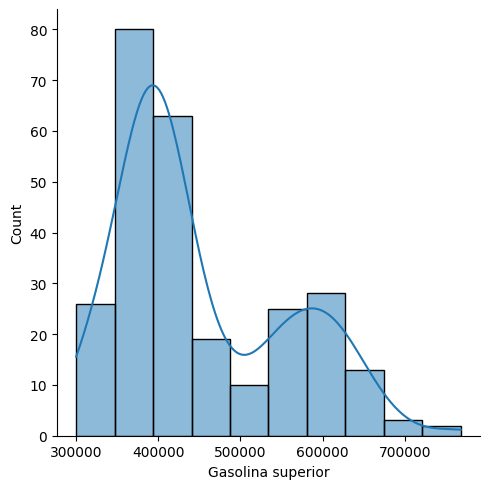

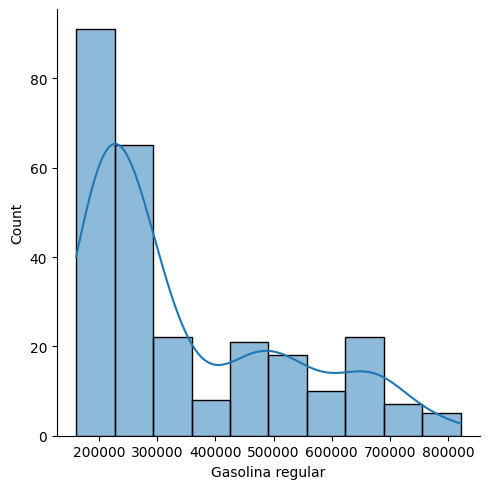

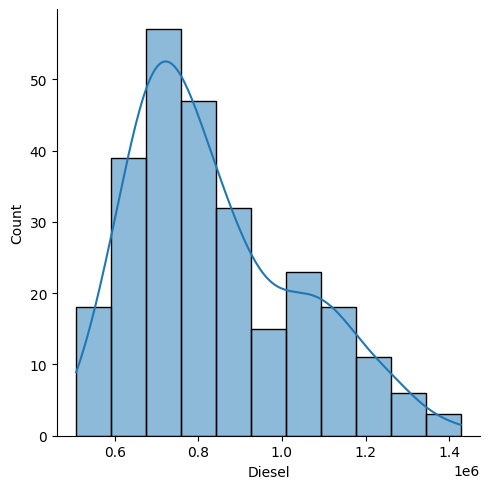

In [90]:
for var in quant_vars:
    data = df[var].dropna(how='all', axis=0)
    
    # Gráfico
    sns.displot(data, kde=True)
    # print('\033[1m' + var + '\033[0m' + ': Kurtosis:', stats.kurtosis(data), 'Skewness:', stats.skew(data), '\n')


# Por año

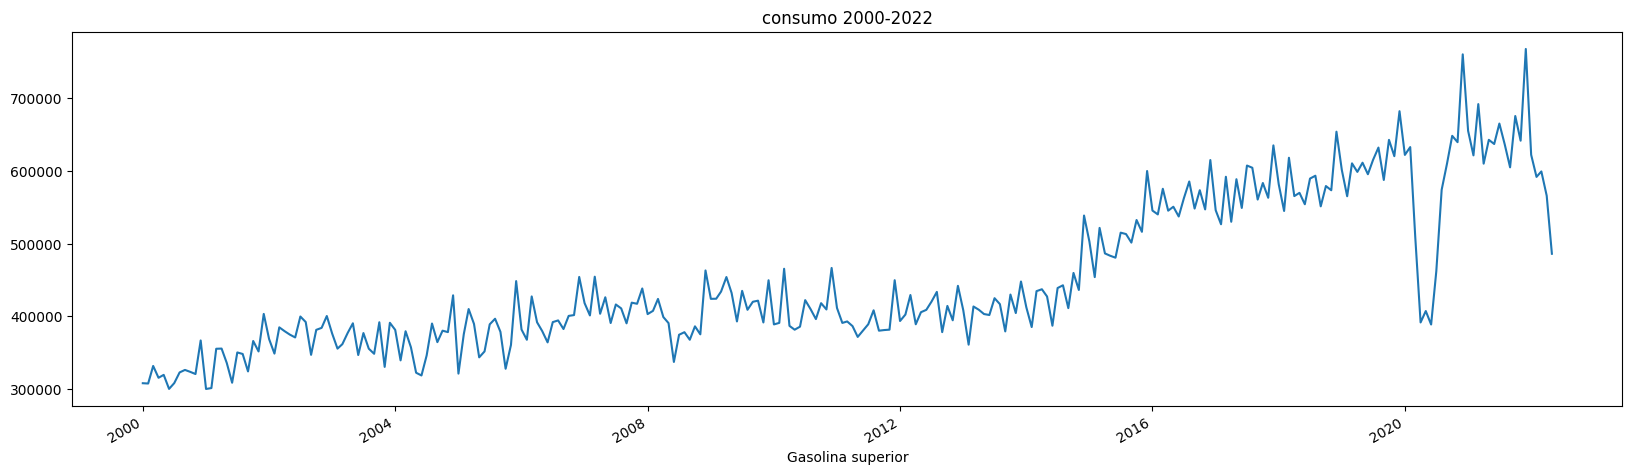

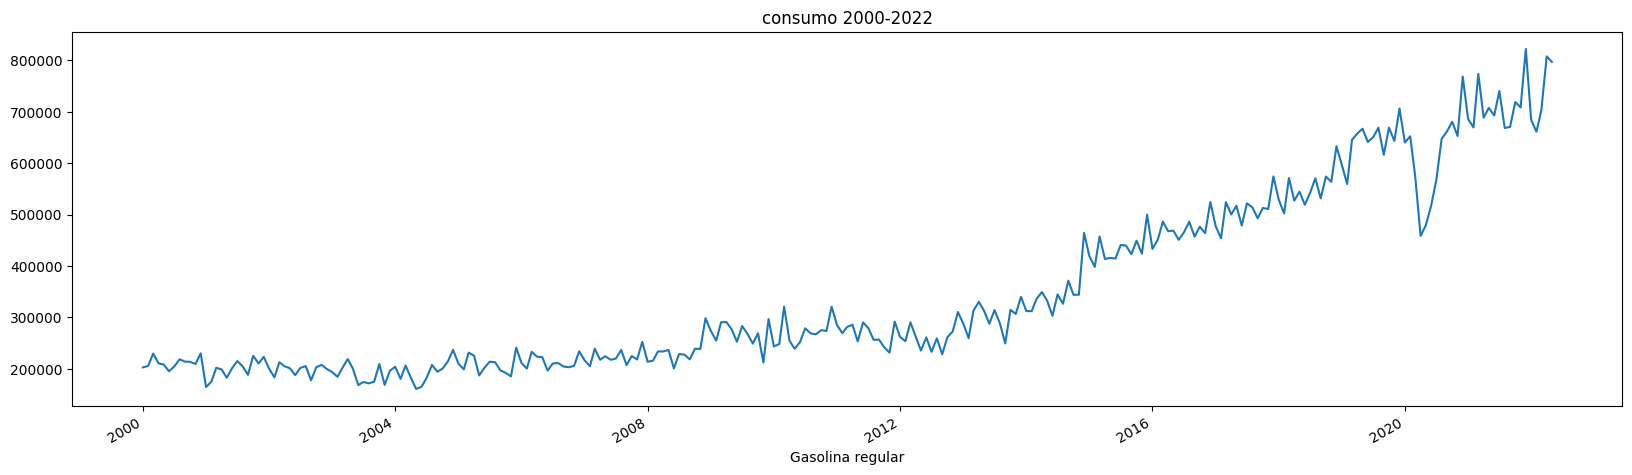

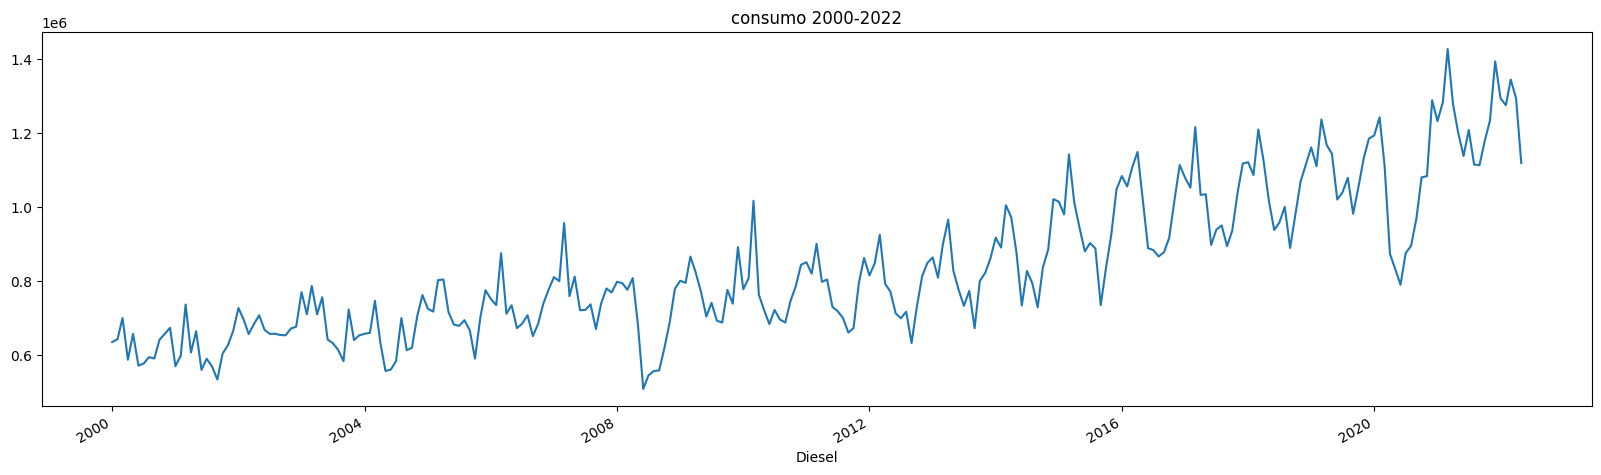

In [91]:
plt.rcParams["figure.figsize"] = (20,5.5)

for gas in quant_vars:
    x = df['Fecha']
    y = df[gas]

    plt.title(dfToUse+" 2000-2022")
    # beautify the x-labels
    plt.gcf().autofmt_xdate()
    plt.xlabel(gas)


    plt.plot(x, y)
    plt.show()

# Por mes

In [92]:
dfPerMonth = df.groupby(df['Fecha'].dt.month)
dfPerMonth = dfPerMonth.sum()

C:\Users\Brand\AppData\Local\Temp\ipykernel_14620\1244651294.py:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.add is deprecated. In a future version, a TypeError will be raised. Before calling .add, select only columns which should be valid for the function.
  dfPerMonth = dfPerMonth.sum()


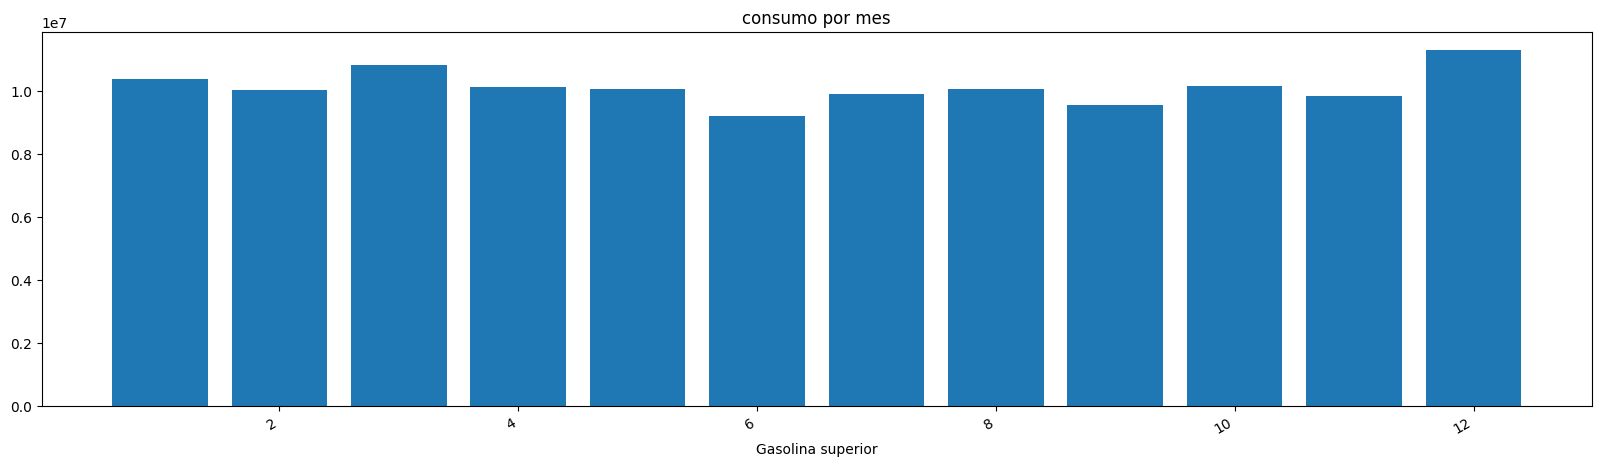

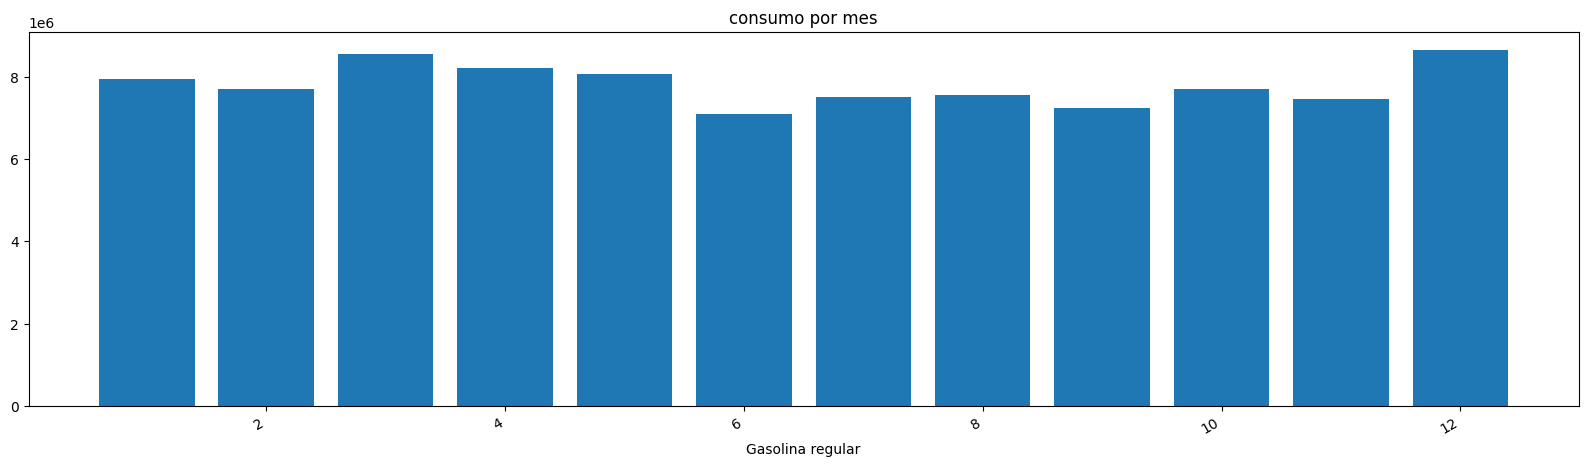

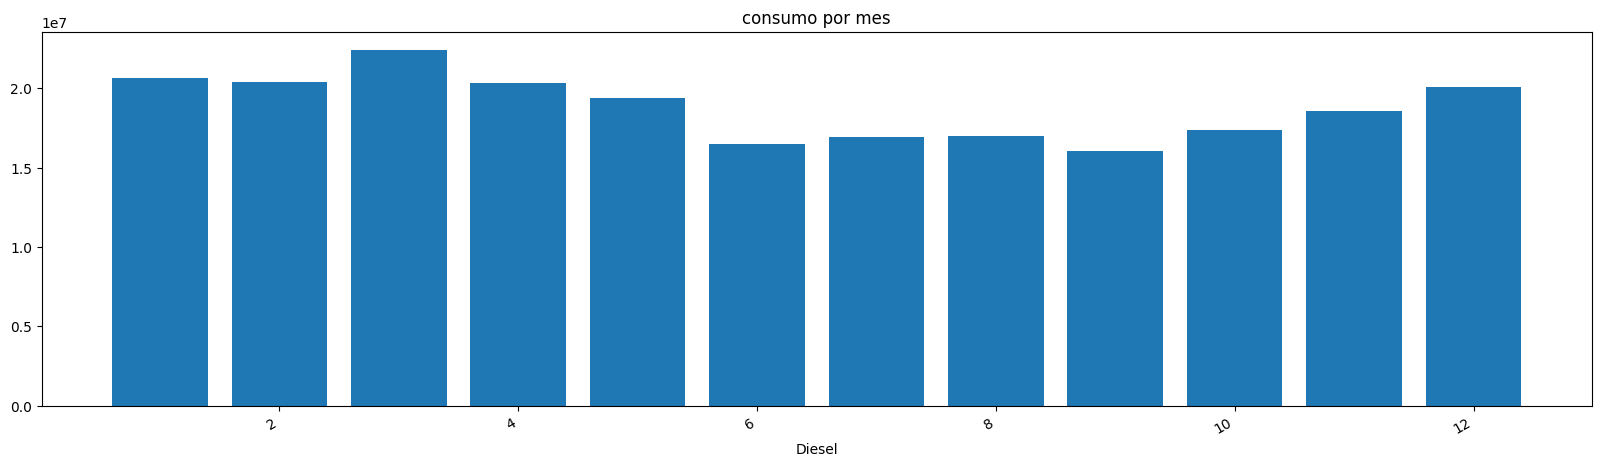

In [93]:
plt.rcParams["figure.figsize"] = (20,5.5)

for gas in quant_vars:
    x = dfPerMonth.index
    y = dfPerMonth[gas]


    plt.title(dfToUse+" por mes")
    # beautify the x-labels
    plt.gcf().autofmt_xdate()
    plt.xlabel(gas)


    plt.bar(x, y)
    plt.show()

# Comportamiento en la pandemia

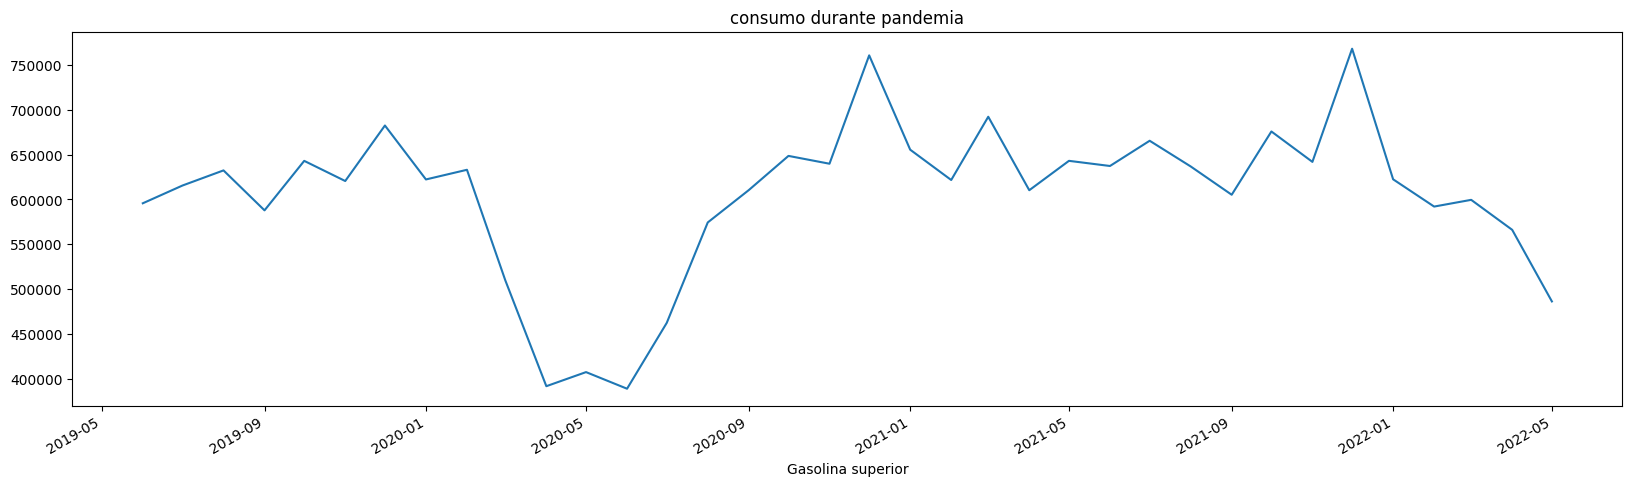

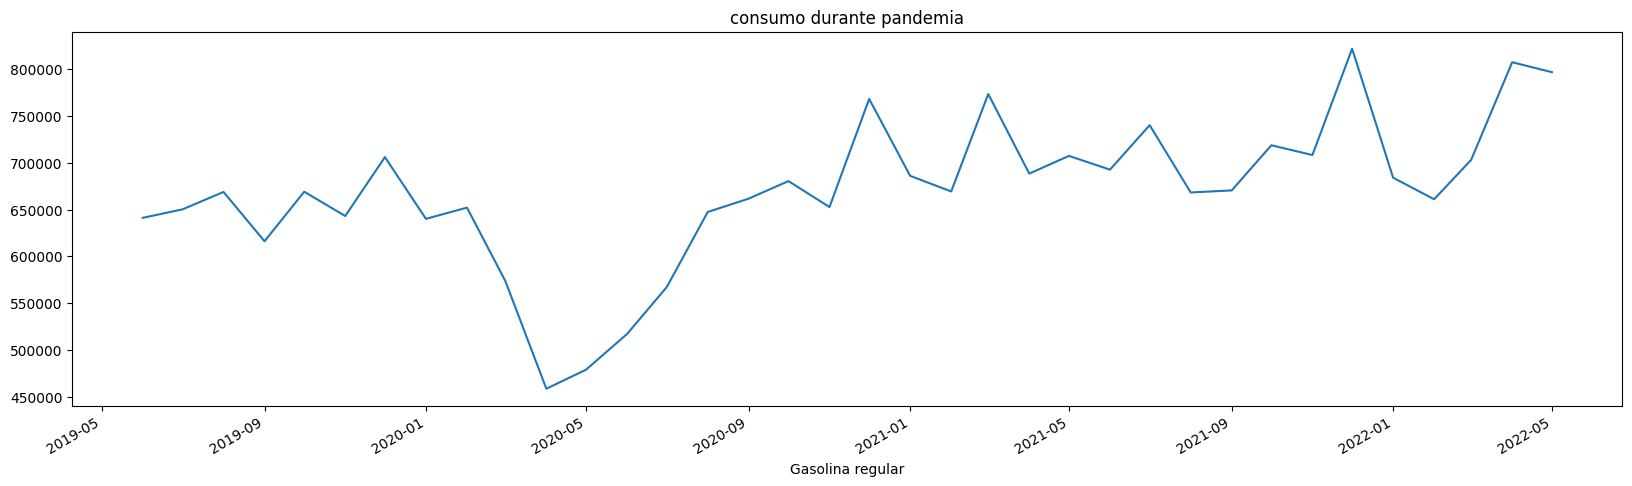

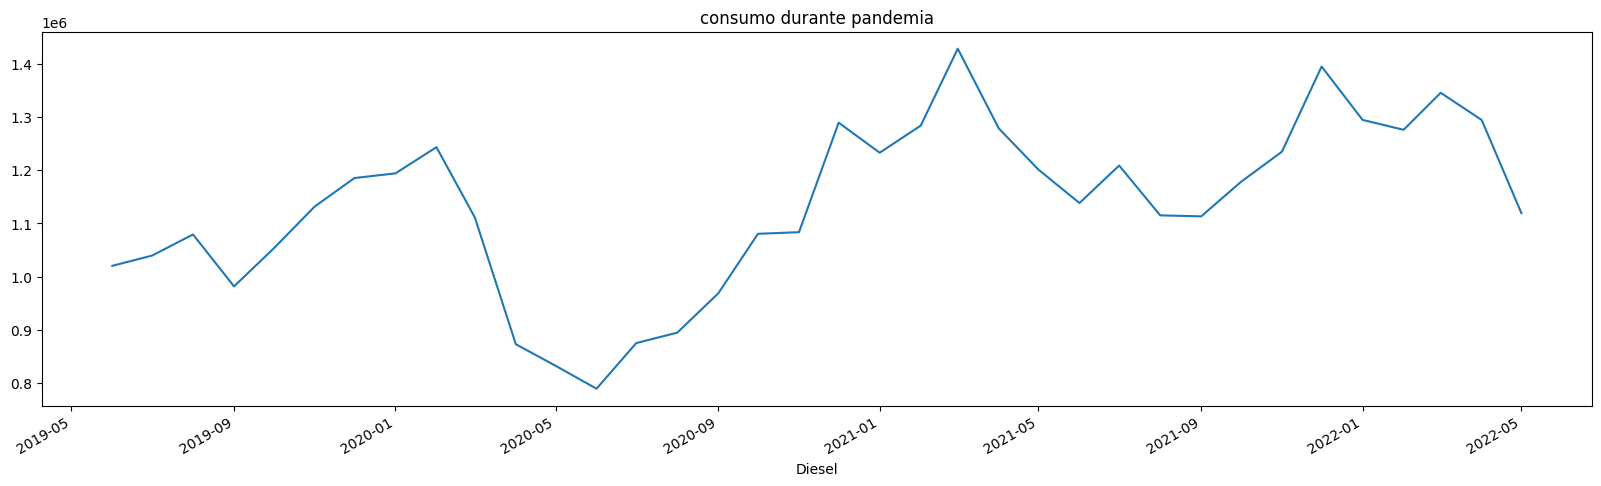

In [94]:
plt.rcParams["figure.figsize"] = (20,5.5)
quant_to_have = 12

for gas in quant_vars:
    x = df['Fecha'].tail(quant_to_have * 3)
    y = df[gas].tail(quant_to_have * 3)

    plt.title(dfToUse+" durante pandemia")
    # beautify the x-labels
    plt.gcf().autofmt_xdate()
    plt.xlabel(gas)


    plt.plot(x, y)
    plt.show()

# Separando test y train

In [95]:
rows = len(df)
train_df = df[0:rows-17]
test_df = df[rows-17:]
print(len(train_df), len(test_df))

252 17


## Pasos para construir modelos ARIMA
1. Identificación
2. Estimación
3. Validación
4. Predicción

In [96]:
def make_timeline(column):
  plt.rcParams["figure.figsize"] = (20,5.5)
  mediaGasoline = train_df[column].rolling(window=12).mean()
  deGasoline = train_df[column].rolling(window=12).std()

  original = plt.plot(train_df[column], color="blue", label="Original")
  media = plt.plot(mediaGasoline, color='red', label = 'Media ' + dfToUse)
  ds = plt.plot(deGasoline, color='black', label = 'Desviación Estándar ' + dfToUse)
  plt.legend(loc = 'best')
  plt.title('Media y desviación estándar ' + column)
  plt.show(block=False)

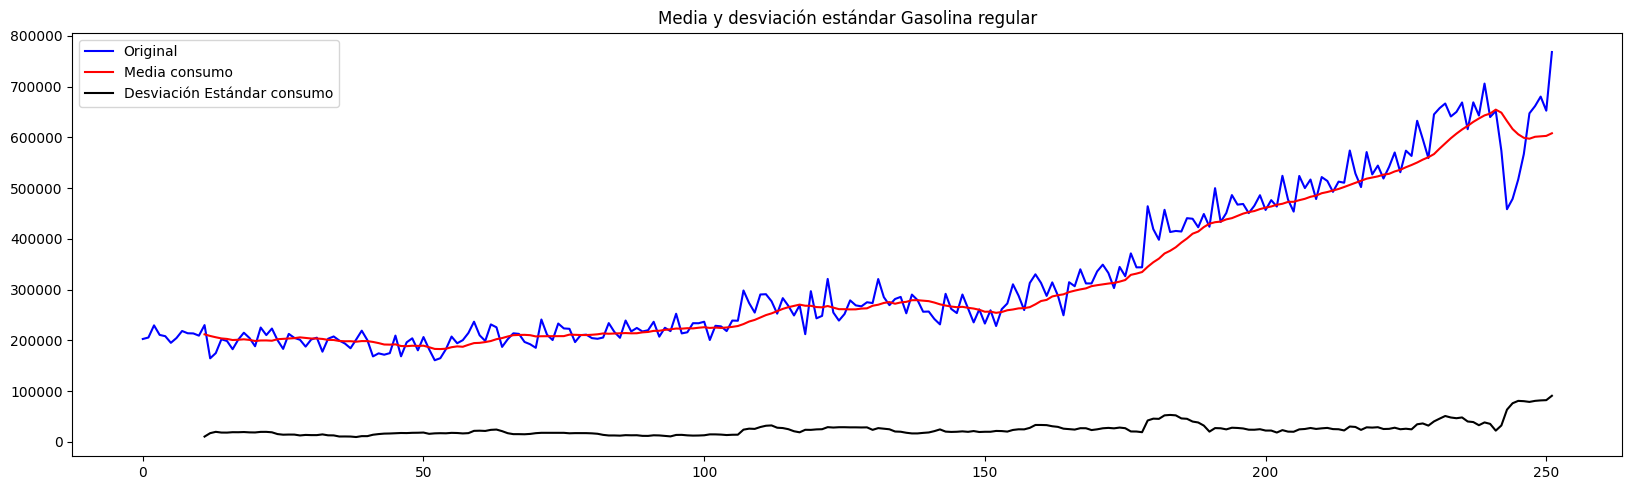

In [97]:
make_timeline('Gasolina regular')

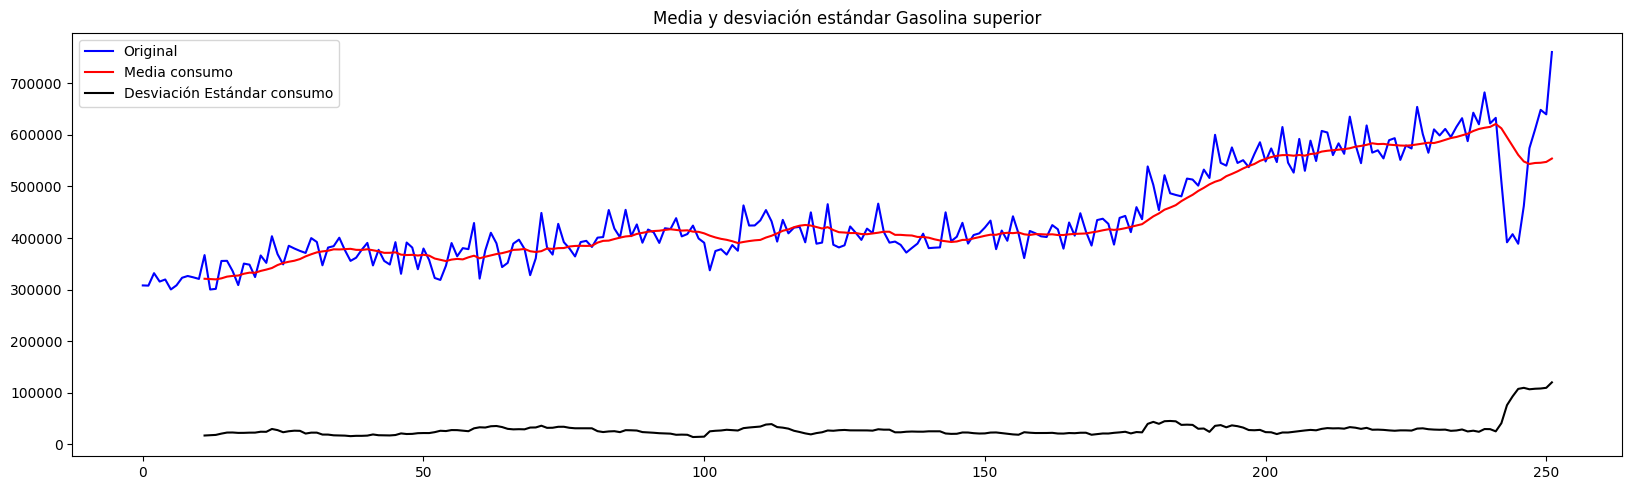

In [98]:
make_timeline('Gasolina superior')

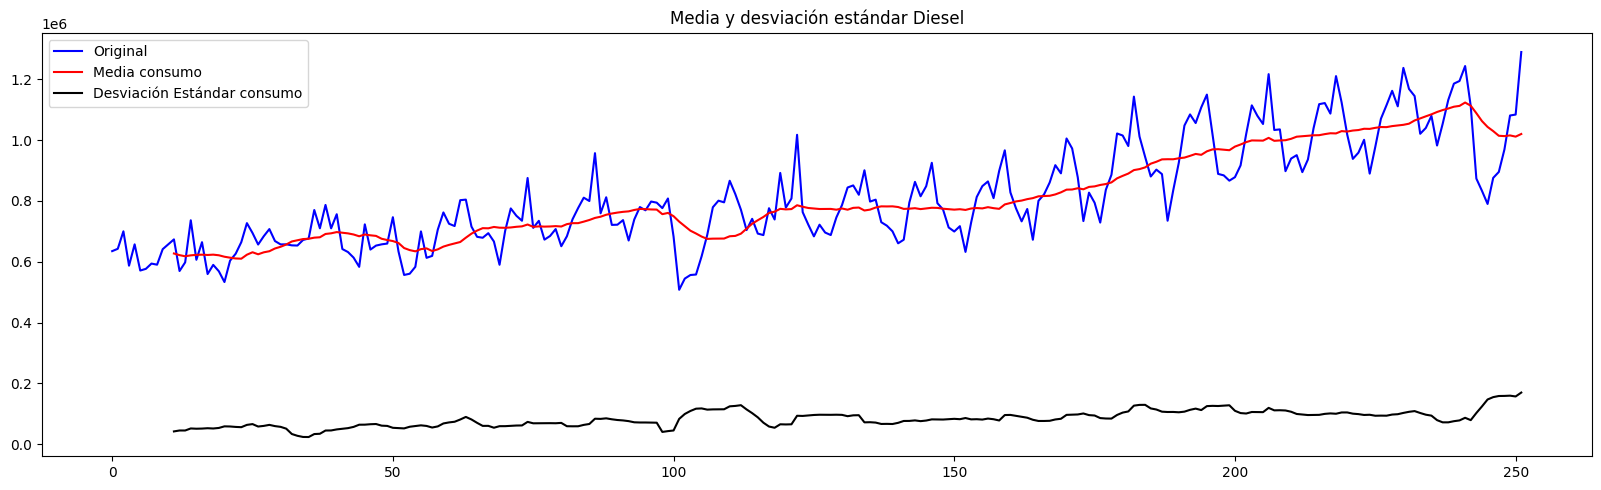

In [99]:
make_timeline('Diesel')

In [100]:
train_regular = train_df[['Fecha', 'Gasolina regular']]
train_superior = train_df[['Fecha', 'Gasolina superior']]
train_diesel = train_df[['Fecha', 'Diesel']]

test_regular = test_df[['Fecha', 'Gasolina regular']]
test_superior = test_df[['Fecha', 'Gasolina superior']]
test_diesel = test_df[['Fecha', 'Diesel']]

In [101]:
# Gasolina regular
train_regular['Gasolina regular'] = train_regular['Gasolina regular'].astype(float)
train_regular_indexed = train_regular.set_index(['Fecha'])
# Gasolina superior
train_superior['Gasolina superior'] = train_superior['Gasolina superior'].astype(float)
train_superior_indexed = train_superior.set_index(['Fecha'])
# Gasolina diesel
train_diesel['Diesel'] = train_diesel['Diesel'].astype(float)
train_diesel_indexed = train_diesel.set_index(['Fecha'])


######### TEST ###############
# Gasolina regular
test_regular['Gasolina regular'] = test_regular['Gasolina regular'].astype(float)
test_regular_indexed = test_regular.set_index(['Fecha'])
# Gasolina superior
test_superior['Gasolina superior'] = test_superior['Gasolina superior'].astype(float)
test_superior_indexed = test_superior.set_index(['Fecha'])
# Gasolina diesel
test_diesel['Diesel'] = test_diesel['Diesel'].astype(float)
test_iesel_indexed = test_diesel.set_index(['Fecha'])

In [102]:
train_regular_indexed

,Gasolina regular
Fecha,
2000-01-01,202645.20
2000-02-01,205530.96
2000-03-01,229499.56
2000-04-01,210680.40
2000-05-01,208164.34
...,...
2020-08-01,647375.58
2020-09-01,661665.58
2020-10-01,680362.07


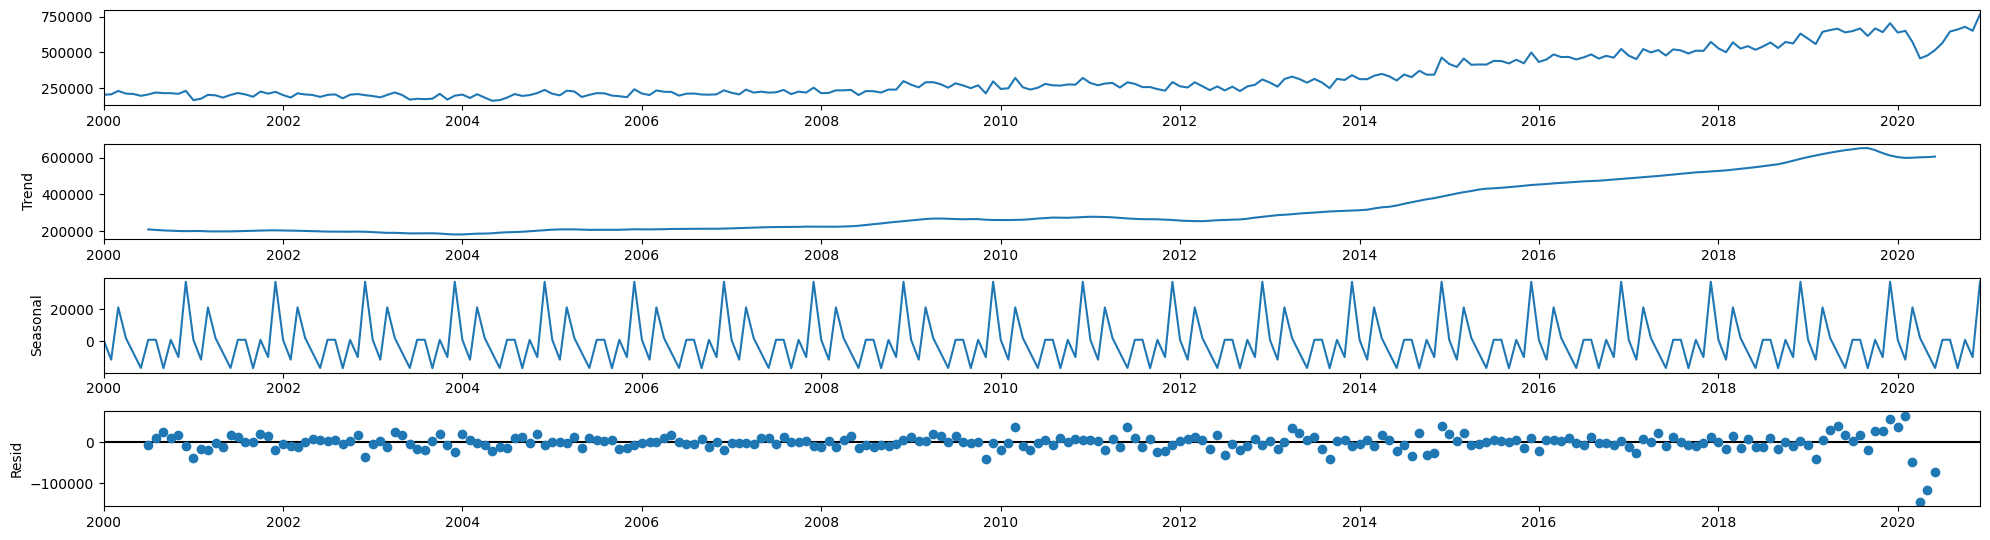

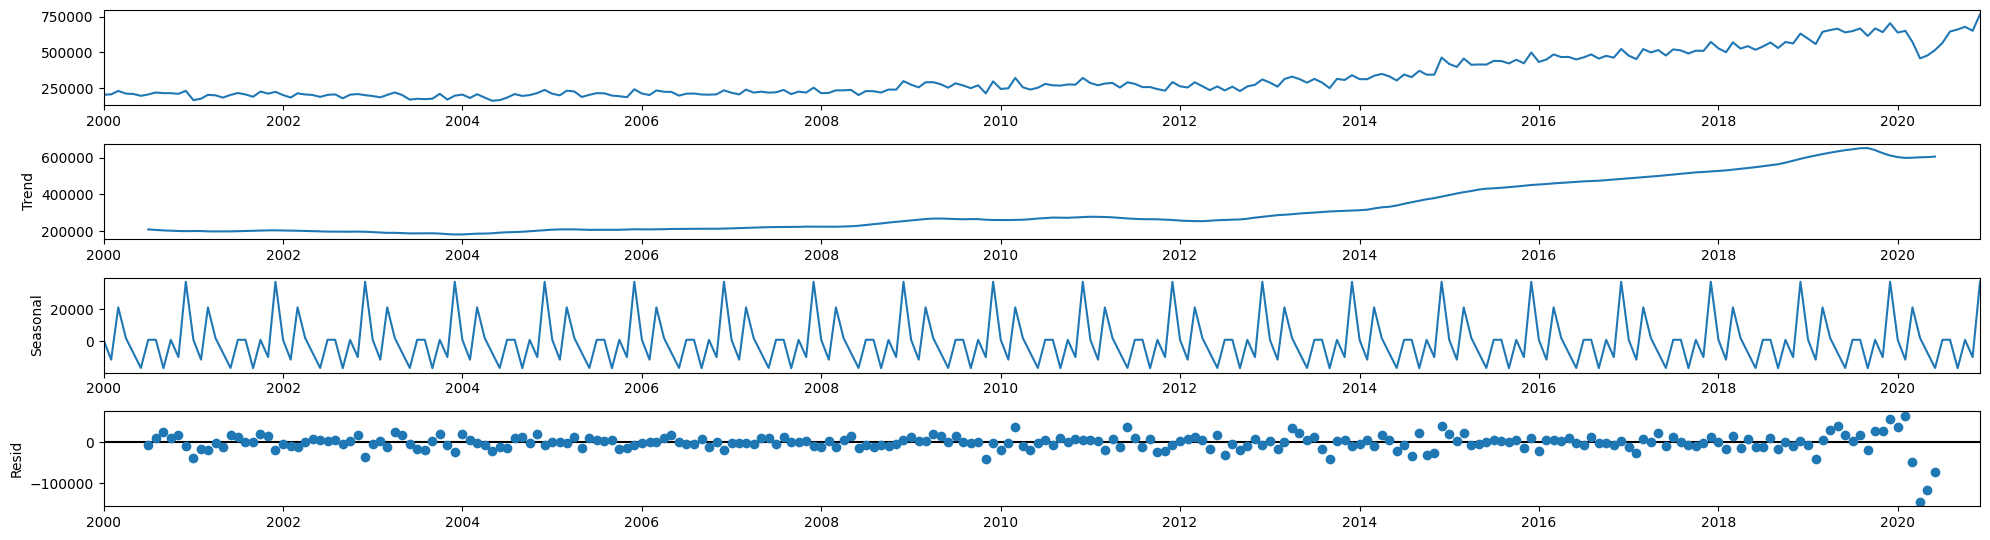

In [103]:
descomposicion = seasonal_decompose(train_regular_indexed)
descomposicion.plot()

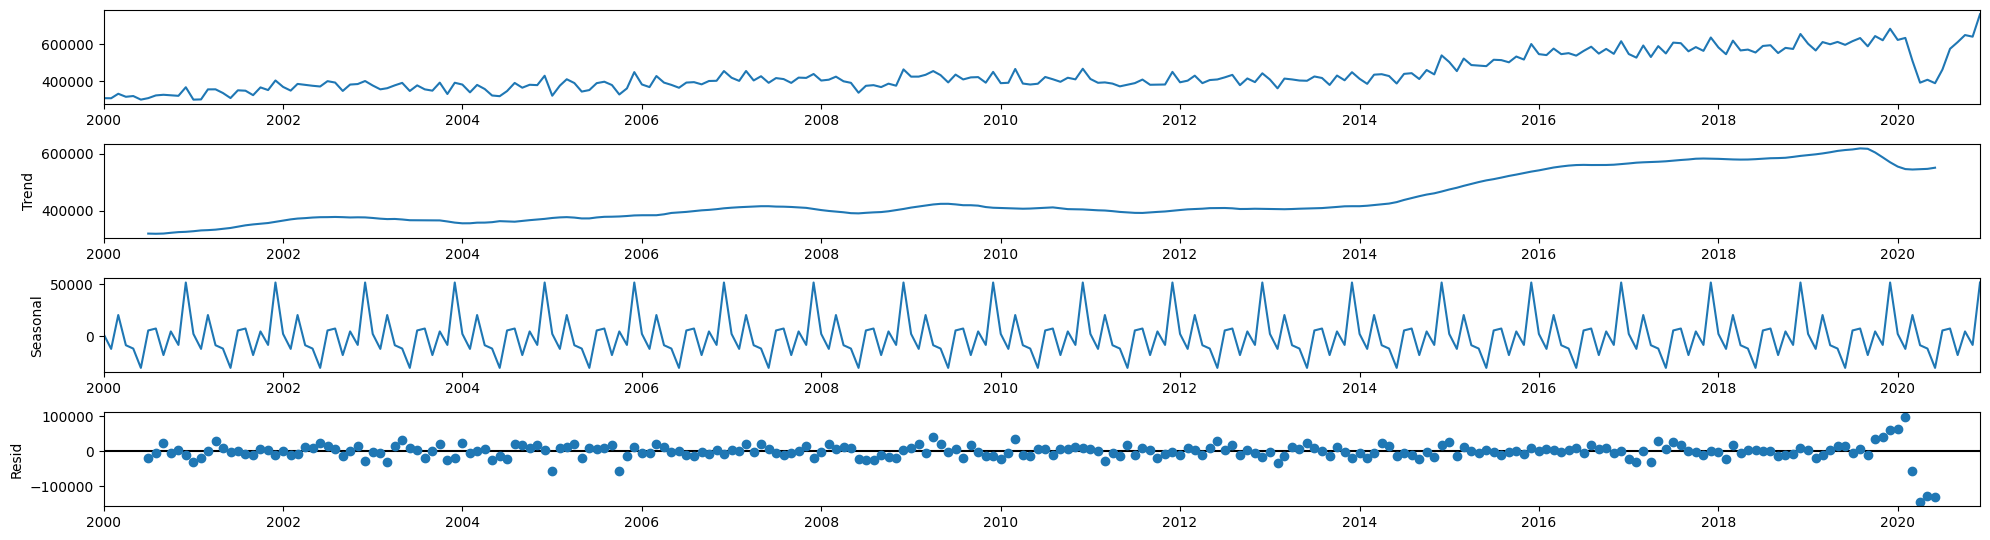

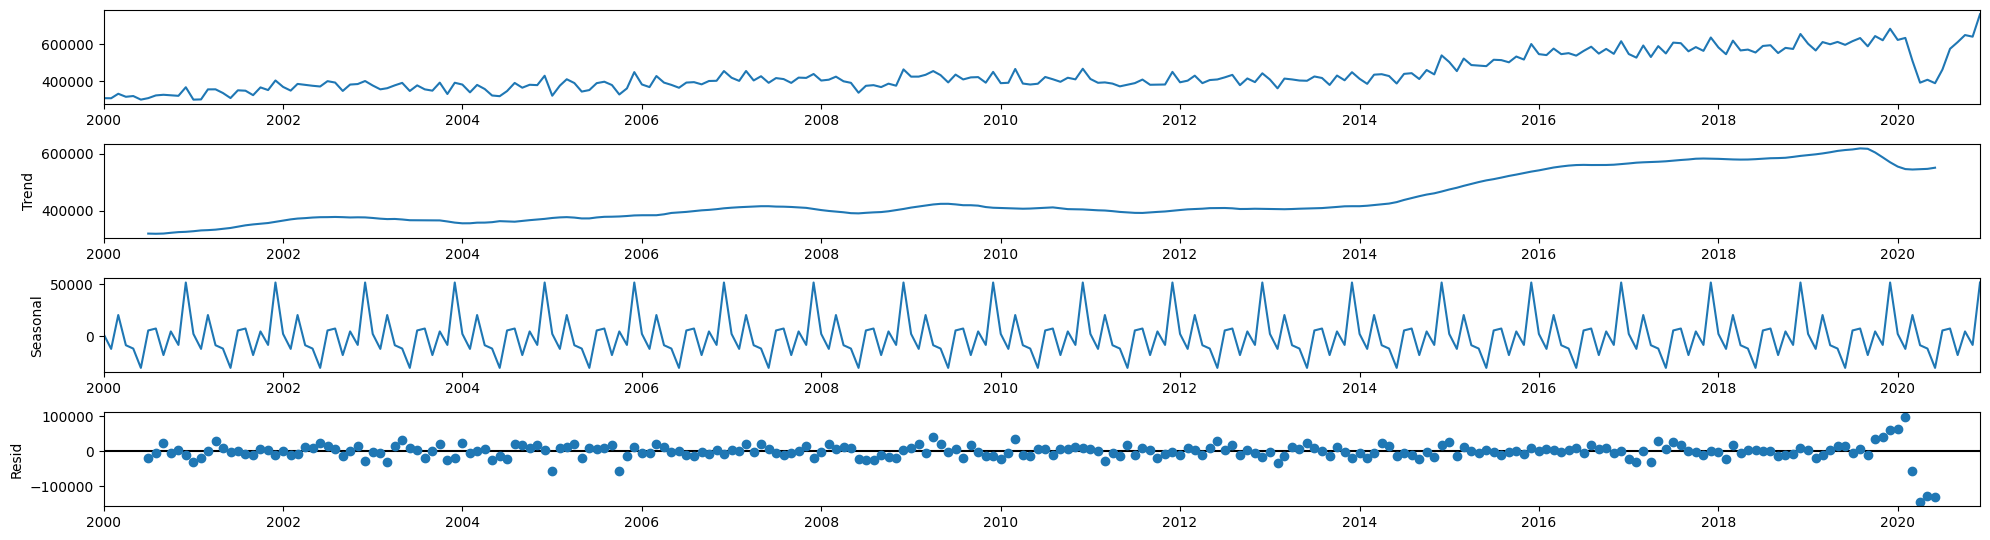

In [104]:
descomposicion = seasonal_decompose(train_superior_indexed)
descomposicion.plot()

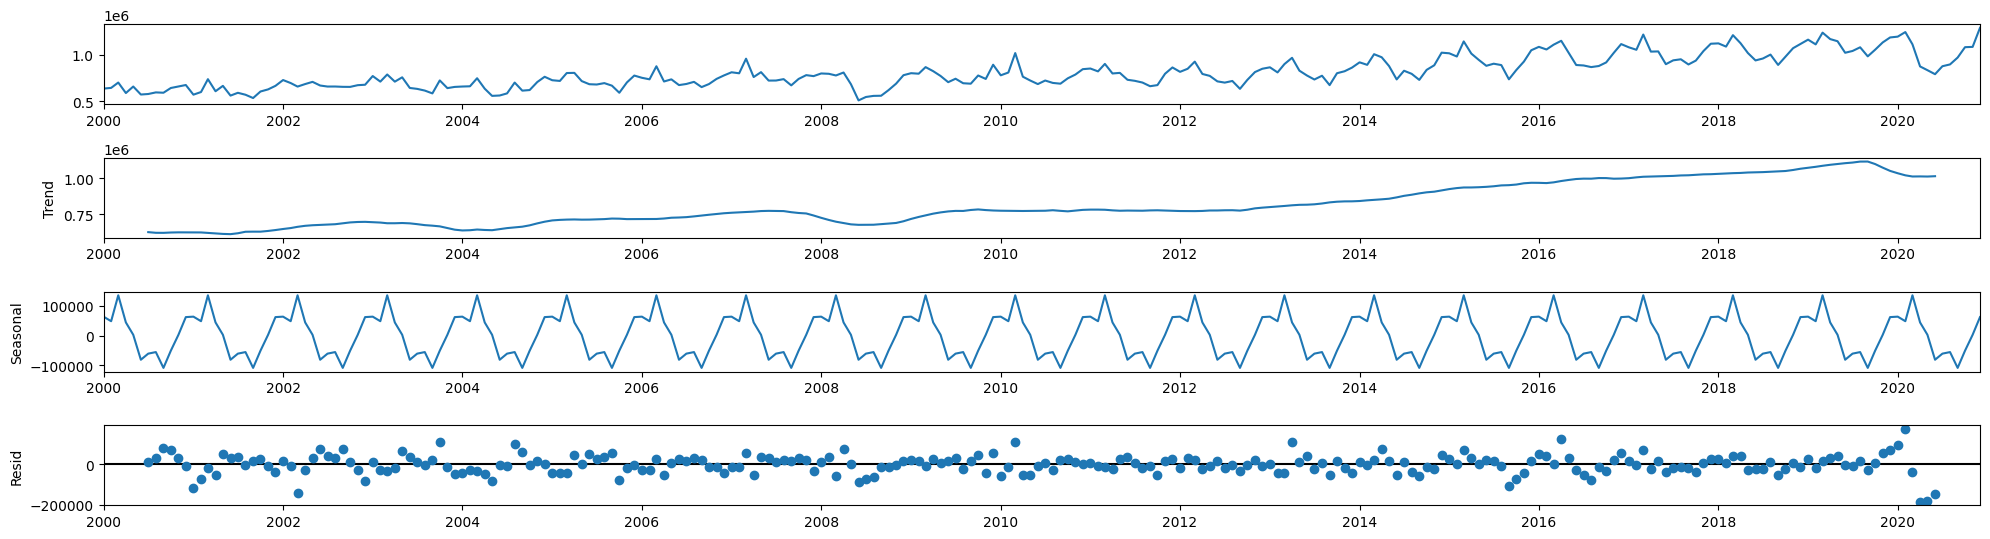

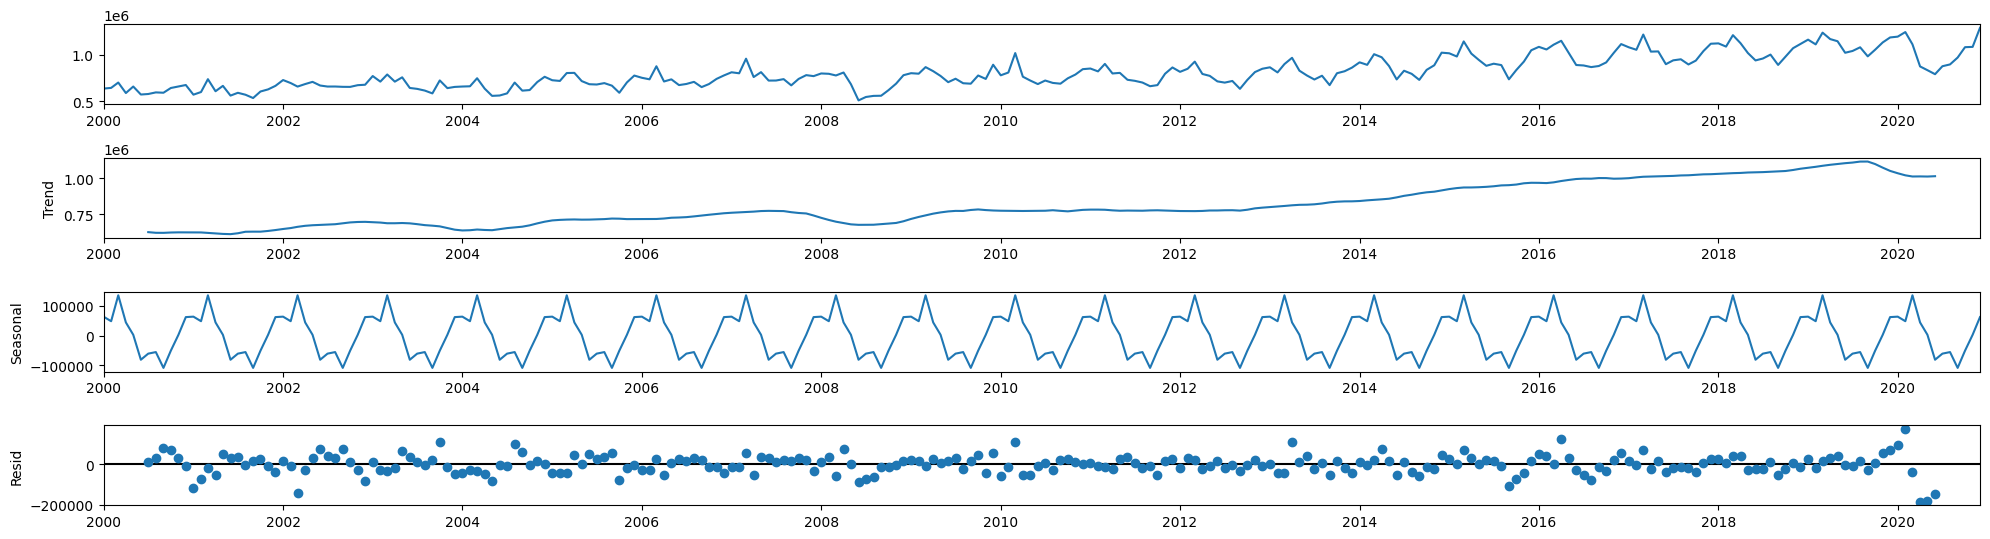

In [105]:
descomposicion = seasonal_decompose(train_diesel_indexed)
descomposicion.plot()

# Estimación

In [106]:
train_regular_indexed = train_regular_indexed[0:240]
train_superior_indexed = train_superior[0:240]
train_diesel_indexed = train_diesel[0:240]

In [107]:
train_regular_indexed

,Gasolina regular
Fecha,
2000-01-01,202645.20
2000-02-01,205530.96
2000-03-01,229499.56
2000-04-01,210680.40
2000-05-01,208164.34
...,...
2019-08-01,668783.39
2019-09-01,616079.30
2019-10-01,669008.77


Estacionar en varianza

In [108]:
train_regular_gas = train_regular_indexed['Gasolina regular']

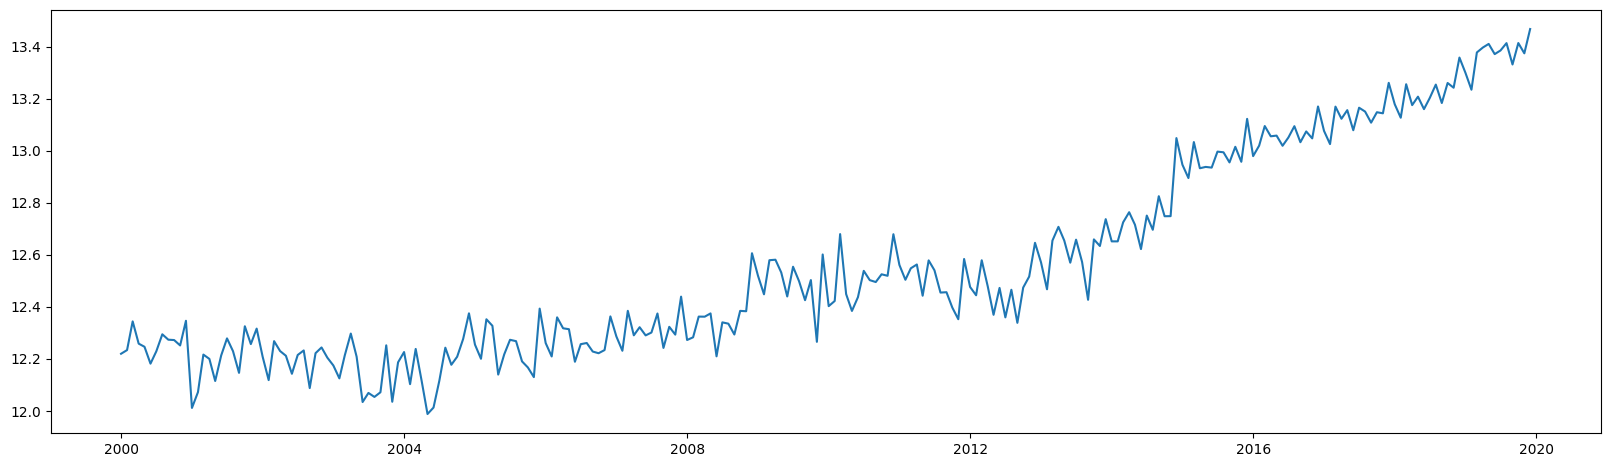

In [109]:
train_regular_log = np.log(train_regular_gas)
plt.plot(train_regular_log)

Con esta transformación pudimos estacionarizarla en varianza debido a que los picos se mantienen

In [110]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(train_regular_gas, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba          3.154508
p-value                        1.000000
# de retardos usados          12.000000
# de observaciones usadas    227.000000
Critical Value (1%)           -3.459490
Critical Value (5%)           -2.874358
Critical Value (10%)          -2.573602
dtype: float64


El p-value es mayor a 0.05 por lo que no se puede rechazar la hipótesis nula de que existen raices unitarias. La serie no es estacionaria en media. Vamos a probar con una diferenciación

In [111]:
print('Resultados del Test de Dickey Fuller para una diferenciación de la serie')
train_regular_gas_log_diff = train_regular_gas.diff()
train_regular_gas_log_diff.dropna(inplace=True)
dfTest = adfuller(train_regular_gas_log_diff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller para una diferenciación de la serie
Estadístico de prueba         -3.431888
p-value                        0.009919
# de retardos usados          12.000000
# de observaciones usadas    226.000000
Critical Value (1%)           -3.459620
Critical Value (5%)           -2.874415
Critical Value (10%)          -2.573632
dtype: float64


El p-value es menor a 0.05 por lo que se rechaza la hipótesis nula. La serie es estacionaria en media con un d=1

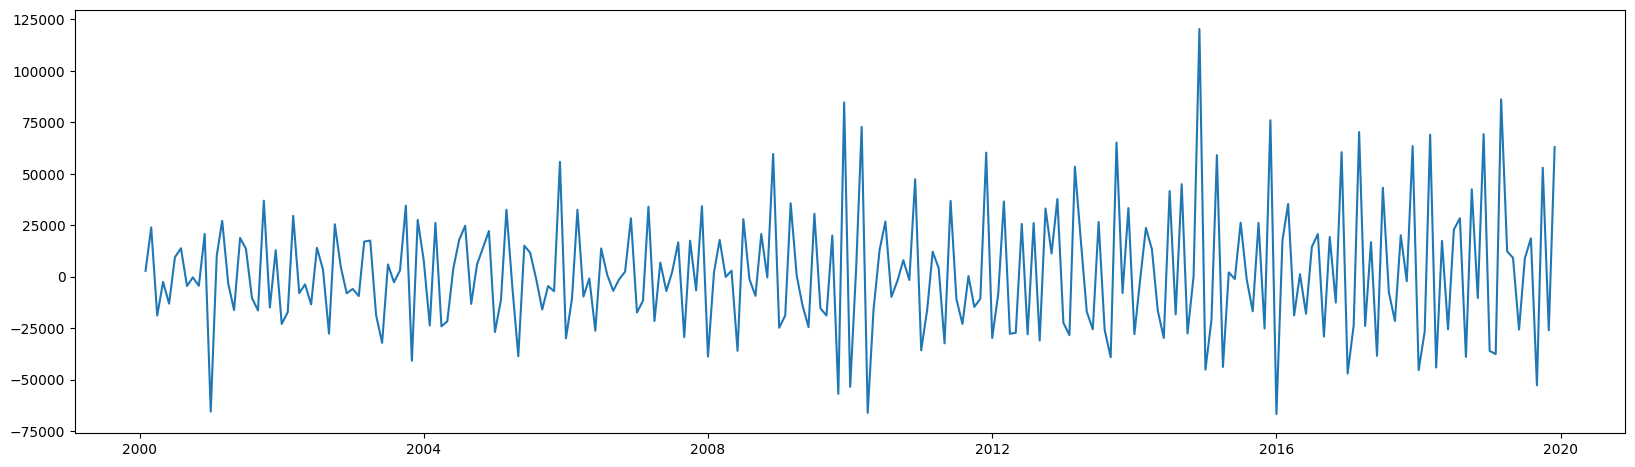

In [112]:
plt.plot(train_regular_gas_log_diff)

### Funciones de autocorrelación
#### Modelos teóricos


| Modelo    |                FAC                |                FACP               |
|-----------|:---------------------------------:|:---------------------------------:|
|   **MA(q)**   |         Se anula para j>q         | Decrecimiento rápido. No se anula |
|   **AR(p)**   | Decrecimiento rápido. No se anula |         Se anula para j>p         |
| **ARMA(p,q)** | Decrecimiento rápido. No se anula | Decrecimiento rápido. No se anula |  

In [113]:
train_regular_gas_diff = train_regular_log.diff()
train_regular_gas_diff.dropna(inplace = True)
tsa_acf = acf(train_regular_gas_diff,nlags=5,fft=False)
tsa_pacf = pacf(train_regular_gas_diff, nlags=36)
tsa_acf

array([ 1.        , -0.43251711, -0.14227986,  0.14891018, -0.04858585,
        0.15916638])

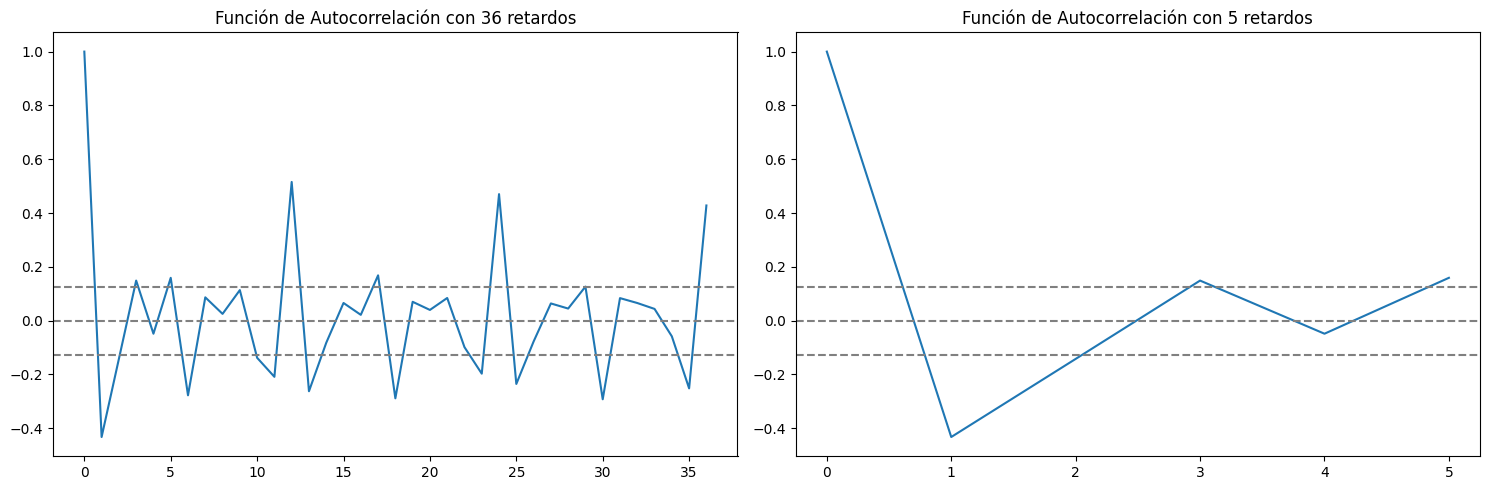

In [114]:

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(train_regular_gas_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_regular_gas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_regular_gas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')

plt.subplot(122) 
plt.plot(acf(train_regular_gas_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_regular_gas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_regular_gas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 retardos')

plt.tight_layout()

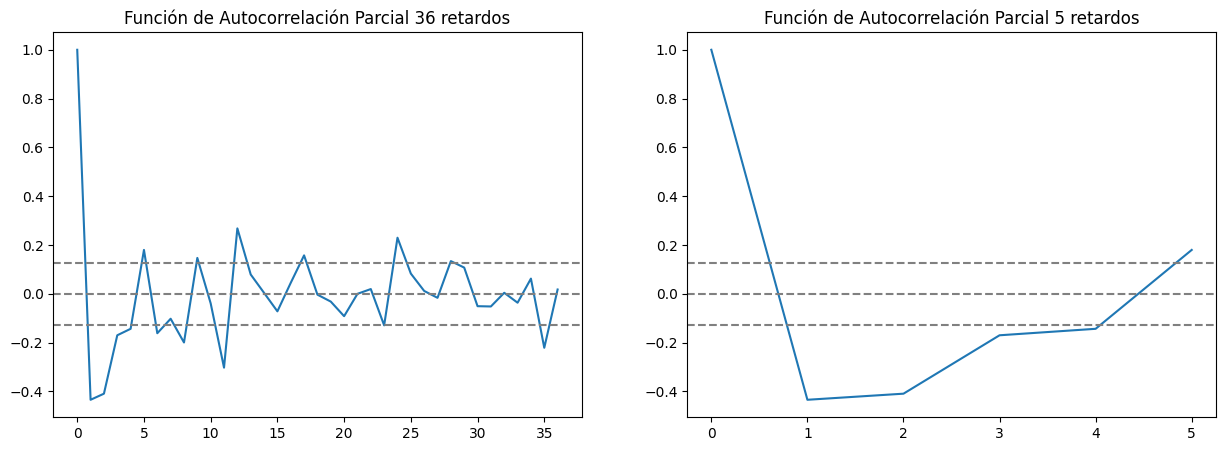

In [115]:
#plot PACF
plt.subplot(121)
plt.plot(pacf(train_regular_gas_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_regular_gas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_regular_gas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 retardos')

plt.subplot(122)
plt.plot(pacf(train_regular_gas_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_regular_gas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_regular_gas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

- Al verificar ACF el modelo no se anula
- Al verificar PACF el modelo no se anula

---> Se acerca a un ARMA

#### Estacionalidad

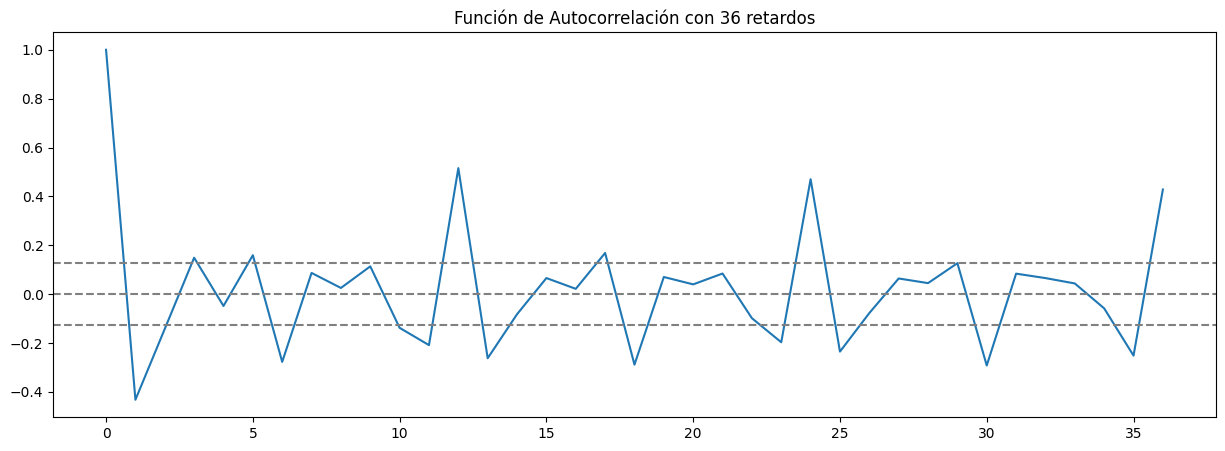

In [116]:
plt.plot(acf(train_regular_gas_diff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_regular_gas_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_regular_gas_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Como se puede observar el comportamiento es similar entre 3 - 12 y 15 - 24 (estacionalidad)

In [117]:
train_regular_log_diff = train_regular_log.diff(12)
train_regular_log_diff.dropna(inplace=True)

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 8 retardos')

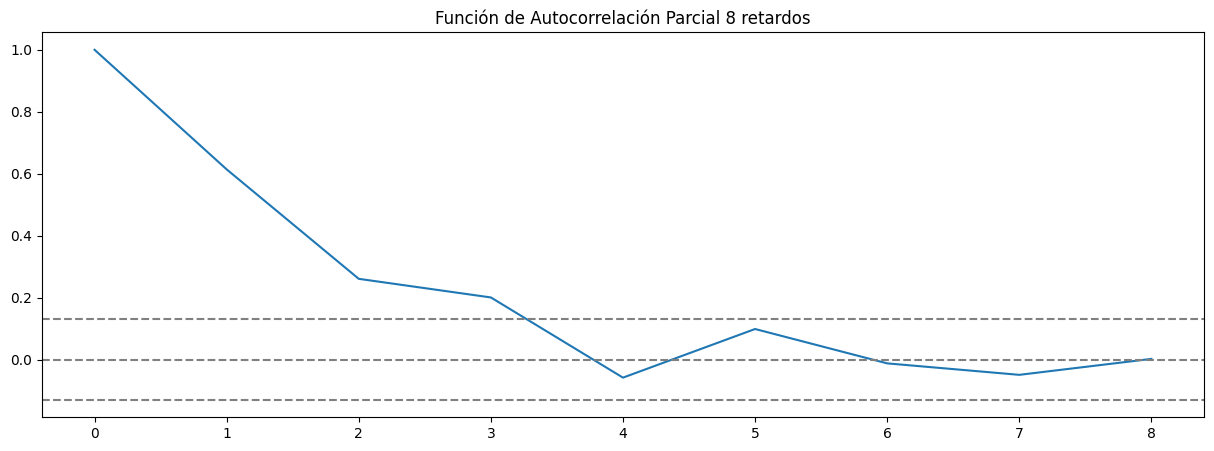

In [118]:

plt.plot(pacf(train_regular_log_diff, nlags=8))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_regular_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_regular_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 8 retardos')


Luego de hacer una diferenciación estacional, podemos observar que prácticamente se anulan los coeficientes después de p=3. 
- P = 3
- D = 1
- Q = 0

### Analisis residuos

In [119]:
modelo121 = SARIMAX(train_regular_log, order=(1,2,1), seasonal_order=(3,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m121 = modelo121.fit()
print(resultado_m121.summary().tables[1])

c:\Users\Brand\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Brand\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4416      0.062     -7.088      0.000      -0.564      -0.319
ma.L1         -1.0000    172.014     -0.006      0.995    -338.140     336.140
ar.S.L12      -0.7043      0.057    -12.461      0.000      -0.815      -0.593
ar.S.L24      -0.4608      0.078     -5.910      0.000      -0.614      -0.308
ar.S.L36      -0.2647      0.070     -3.799      0.000      -0.401      -0.128
sigma2         0.0047      0.802      0.006      0.995      -1.567       1.576


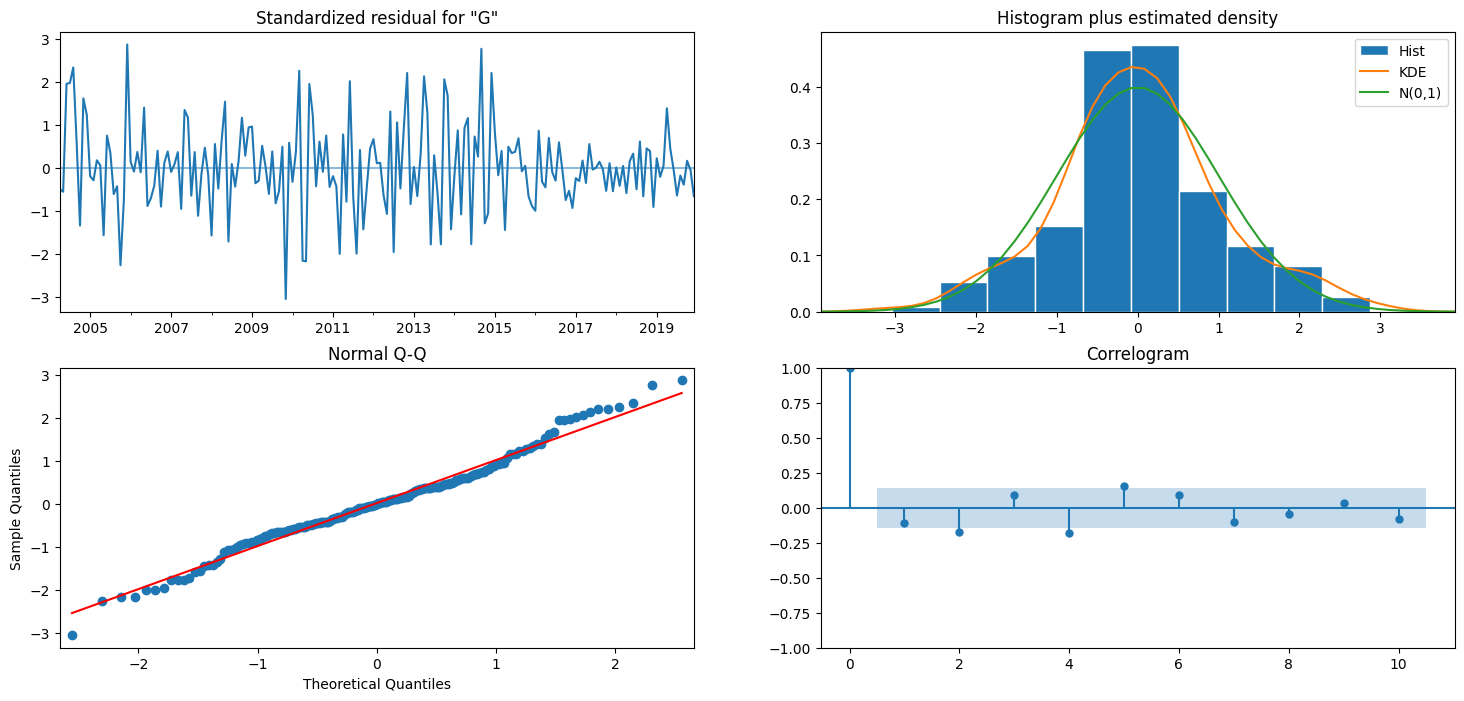

In [120]:
resultado_m121.plot_diagnostics(figsize=(18, 8))
plt.show()

In [121]:
modelo221 = SARIMAX(train_regular_log, order=(2,2,1), seasonal_order=(2,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m221 = modelo221.fit(disp=False)
print(resultado_m221.summary().tables[1])

c:\Users\Brand\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Brand\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5229      0.067     -7.750      0.000      -0.655      -0.391
ar.L2         -0.2735      0.062     -4.393      0.000      -0.396      -0.151
ma.L1         -1.0000     34.836     -0.029      0.977     -69.277      67.277
ar.S.L12      -0.6208      0.065     -9.499      0.000      -0.749      -0.493
ar.S.L24      -0.2771      0.065     -4.262      0.000      -0.405      -0.150
sigma2         0.0051      0.179      0.029      0.977      -0.345       0.356


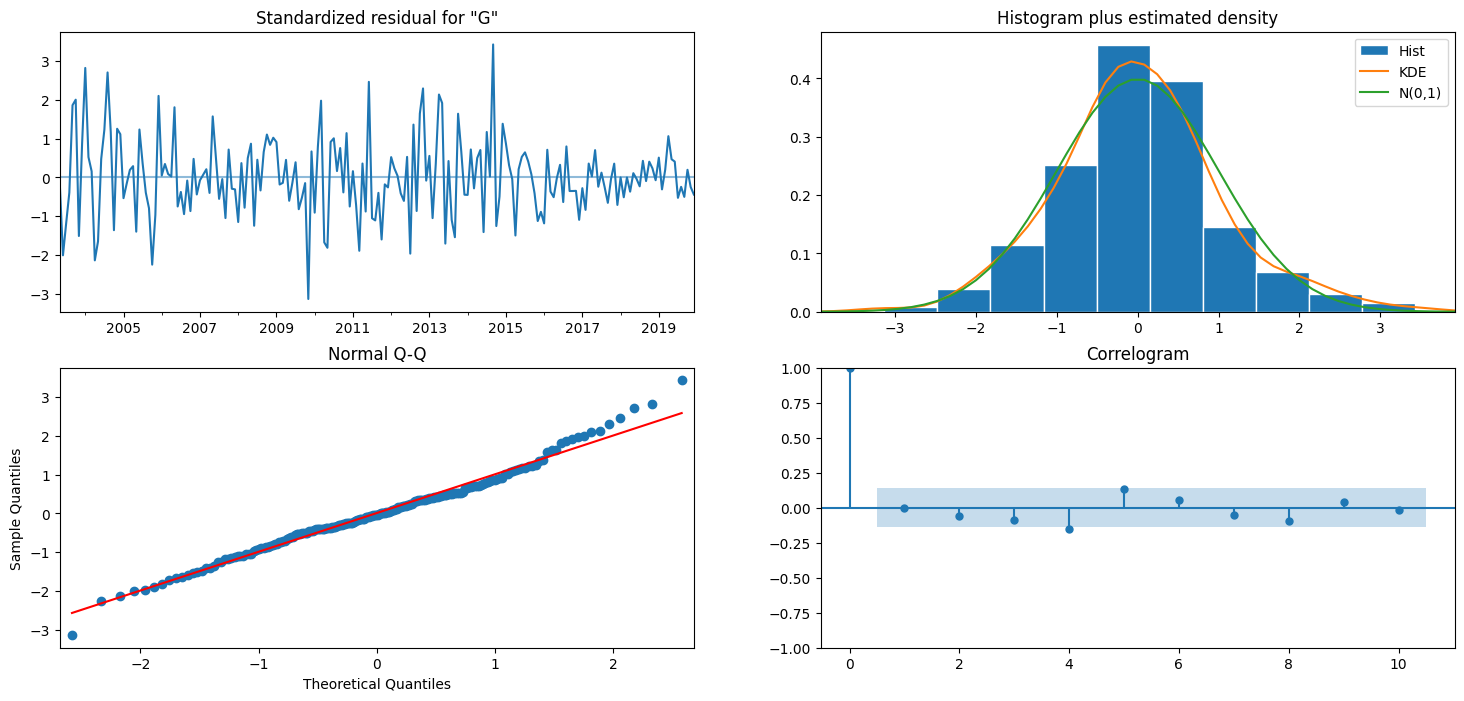

In [122]:
resultado_m221.plot_diagnostics(figsize=(18, 8))
plt.show()

In [123]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 121=",resultado_m121.aic)
print("Modelo 221=",resultado_m221.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 121=",resultado_m121.bic)
print("Modelo 221=",resultado_m221.bic)

Resultados de AIC (Akaike information criterion)
Modelo 121= -461.36481418932914
Modelo 221= -470.2195877549091
Resultados de BIC (Bayesian information criterion)
Modelo 121= -441.9143320989713
Modelo 221= -450.4296835556209


De acuerdo a ambos indicadores es mejor el modelo p=2, d=2, q=1 por lo que este es el que será usado para predecir pues tinene un valor menor en AIC y en BIC

## Predicción con el mejor modelo

In [124]:
test_regular_indexed.index[0]

Timestamp('2021-01-01 00:00:00')

In [125]:
df_regular_indexed = df[['Fecha', 'Gasolina superior']]
df_regular_indexed =  df_regular_indexed.set_index(['Fecha'])
df_regular_indexed['2021-01-01':]

,Gasolina superior
Fecha,
2021-01-01,655512.66
2021-02-01,621712.09
2021-03-01,692240.49
2021-04-01,610310.75
2021-05-01,643076.84
2021-06-01,637332.81
2021-07-01,665472.94
2021-08-01,636824.61
2021-09-01,605257.76


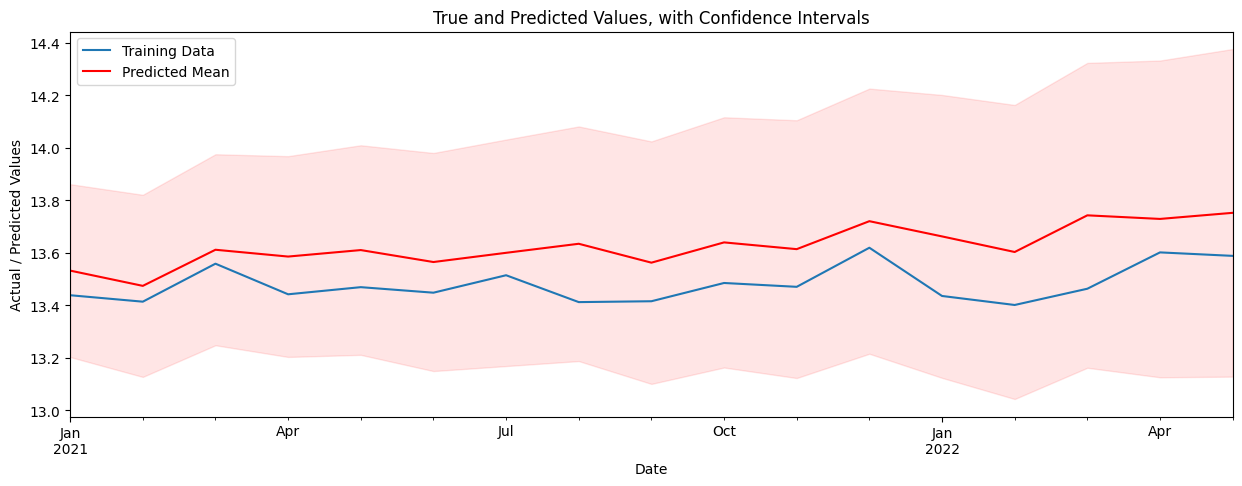

In [127]:
pred = resultado_m221.get_prediction(
  start=test_regular_indexed.index[0],
  end=test_regular_indexed.index[-1],
).summary_frame(alpha=0.05)

fig, ax = plt.subplots(figsize=(15,5))
test_regular_log = np.log(test_regular_indexed['Gasolina regular'])
ax = test_regular_log.plot(label='Training Data')
ax.set(
    title='True and Predicted Values, with Confidence Intervals',
    xlabel='Date',
    ylabel='Actual / Predicted Values'
)

pred['mean'].plot(ax=ax, style='r', label='Predicted Mean')
ax.fill_between(
    pred.index, pred['mean_ci_lower'], pred['mean_ci_upper'],
    color='r', alpha=0.1
)
legend = ax.legend(loc='upper left')
plt.show()